In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import plotly.express as px
from plotly.io import write_html
import plotly.graph_objects as go
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import statsmodels.api as sm
import os

## 1. Read in IPUMS data, calculate State-Year Medians (`median_gross_rents_[year1, year2].csv`)

In [14]:
### INSERT Years, RUN get_median_gross_rents
years = [2004, 2024]
get_median_gross_rents(years)

In [13]:
def get_median_gross_rents(years):

    # Monthly rent data (household level)
    cols = ["YEAR", "STATEFIP", "RENTGRS", "HHWT"]
    gross_rents = []
    for year in years:
        gross_rents.append(pd.read_csv(f'{year}RENTGRS.csv.gz', compression='gzip', usecols=cols))

    gross_rent = pd.concat(gross_rents, ignore_index=True)

    #print(len(gross_rent_combined))
    #gross_rent_combined.head()

    #filtering to get nonzero rent payers (get meaningful median) and years
    gross_rent = gross_rent[gross_rent['YEAR'].isin(years)]
    gross_rent = gross_rent[gross_rent['RENTGRS'] != 0]

    # Calculating medians 
    def weighted_median(x, w):
        s = x.sort_values()
        w = w.loc[s.index].cumsum()
        cutoff = w.iloc[-1] / 2
        return s[w >= cutoff].iloc[0]

    # Group by state and year, then compute median gross rent
    median_rent = gross_rent.groupby(['STATEFIP', 'YEAR']).apply(lambda g: weighted_median(g['RENTGRS'], g['HHWT']))
    median_rent = median_rent.reset_index(name='Median_RENTGRS')
    #median_rent.head()
    #median_rent.to_csv("median_gross_rents.csv", index=False)

    # Convert FIPS Codes
    def fips_to_state_abbrev(fips):
        """Map numeric state FIPS codes to two-letter postal abbreviations."""
        fips_map = {
            1: 'AL', 2: 'AK', 4: 'AZ', 5: 'AR', 6: 'CA', 8: 'CO', 9: 'CT',
            10: 'DE', 11: 'DC', 12: 'FL', 13: 'GA', 15: 'HI', 16: 'ID',
            17: 'IL', 18: 'IN', 19: 'IA', 20: 'KS', 21: 'KY', 22: 'LA',
            23: 'ME', 24: 'MD', 25: 'MA', 26: 'MI', 27: 'MN', 28: 'MS',
            29: 'MO', 30: 'MT', 31: 'NE', 32: 'NV', 33: 'NH', 34: 'NJ',
            35: 'NM', 36: 'NY', 37: 'NC', 38: 'ND', 39: 'OH', 40: 'OK',
            41: 'OR', 42: 'PA', 44: 'RI', 45: 'SC', 46: 'SD', 47: 'TN',
            48: 'TX', 49: 'UT', 50: 'VT', 51: 'VA', 53: 'WA', 54: 'WV',
            55: 'WI', 56: 'WY'
        }
        return fips_map.get(fips, None)

    median_rent['State'] = median_rent['STATEFIP'].map(fips_to_state_abbrev)
    median_rent = median_rent[['YEAR', 'State', 'Median_RENTGRS']]
    #median_rent

    # Convert to weekly amounts

    median_rent['Weekly Median Rent'] = round(median_rent['Median_RENTGRS']/4.345,2)
    median_rent = median_rent[['YEAR', 'State', 'Weekly Median Rent']]
    median_rent = median_rent.rename(columns={"YEAR":"Year"})
    #median_rent
    median_rent.to_csv(f"median_gross_rents_{years}.csv", index=False)
    
    return

## 2. Calculate Changes in Ratios (`changesinrents.csv`)

In [16]:
# Calculate Changes in Ratios
rents_wbas = median_rent.merge(subset, on=['Year', 'State'], how='left')
rents_wbas['Rent Share of Max WBA'] = rents_wbas['Weekly Median Rent'] / rents_wbas['Maximum WBA']
rents_wbas

,Year,State,Weekly Median Rent,Maximum WBA,Rent Share of Max WBA
0,2003,AL,122.21,210.0,0.581952
1,2023,AL,234.75,275.0,0.853636
2,2003,AK,186.42,248.0,0.751694
3,2023,AK,338.32,370.0,0.914378
4,2003,AZ,156.96,205.0,0.765659
...,...,...,...,...,...
97,2023,WV,211.74,630.0,0.336095
98,2003,WI,148.22,329.0,0.450517
99,2023,WI,261.22,370.0,0.706000
100,2003,WY,124.28,296.0,0.419865


In [40]:
def rent_share_diff(group):
    val_2003 = group.loc[group['Year'] == 2003, 'Rent Share of Max WBA'].values
    val_2023 = group.loc[group['Year'] == 2023, 'Rent Share of Max WBA'].values
    return val_2023[0] - val_2003[0]

changes_rents_wbas = rents_wbas.groupby('State').apply(rent_share_diff).reset_index(name='WBA Rent Share Change')
changes_rents_wbas.head()

,State,WBA Rent Share Change
0,AK,0.162685
1,AL,0.271684
2,AR,0.139842
3,AZ,0.456998
4,CA,0.489996


In [41]:
nonindexers_list = ['AK', 'AL', 'AZ', 'CA', 'DE', 'FL', 'GA', 'IN', 'MD', 'MI', 'MO', 'MS', 'NH', 'NY', 'TN', 'VA', 'WI']

def nonindexer(state):
    if state in nonindexers_list:
        return 1
    else:
        return 0

changes_rents_wbas['Nonindexer'] = changes_rents_wbas['State'].apply(nonindexer)
changes_rents_wbas.head()

,State,WBA Rent Share Change,Nonindexer
0,AK,0.162685,1
1,AL,0.271684,1
2,AR,0.139842,0
3,AZ,0.456998,1
4,CA,0.489996,1


In [42]:
changes_rents_wbas.to_csv("changesinrents.csv")

In [43]:
vmin, vmax = -0.5, 1.0
mid = (0 - vmin) / (vmax - vmin)  # -> 0.3333333333

colorscale3 = [
    [0.00, 'rgba(50,50,100,0.8)'],     # negative end (blue)
    [mid*0.7, 'rgba(200,200,255,0.85)'],# slight blue near 0-
    [mid,  'white'],                    # exactly 0
    [mid + (1-mid)*0.3, 'rgba(255,210,130,0.85)'], # light orange
    [1.00, 'rgba(255,165,0,0.9)']       # positive end (orange)
]

bins = [-0.5, 0, 0.2, 0.4, 0.6, 0.8, 1]
labels = ['Less than 0%', '0-20%', '20-40%', '40-60%', '60-80%', '80-100%']
changes_rents_wbas['WBA Rent Share Change'] = pd.cut(changes_rents_wbas['WBA Rent Share Change'], bins=bins, labels=labels, include_lowest=True)

color_map = {
    'Less than 0%': '#D3D3D3',       
    '0-20%': '#fee6ce',
    '20-40%': '#fdae6b',
    '40-60%': '#ffa641',
    '60-80%': 'rgba(50,50,100,0.8)',
    '80-100%': '#ff7700'    
}

category_order = ['Less than 0%', '0-20%', '20-40%', '40-60%', '60-80%', '80-100%']
changes_rents_wbas['WBA Rent Share Change'] = pd.Categorical(changes_rents_wbas['WBA Rent Share Change'], categories=category_order, ordered=True)


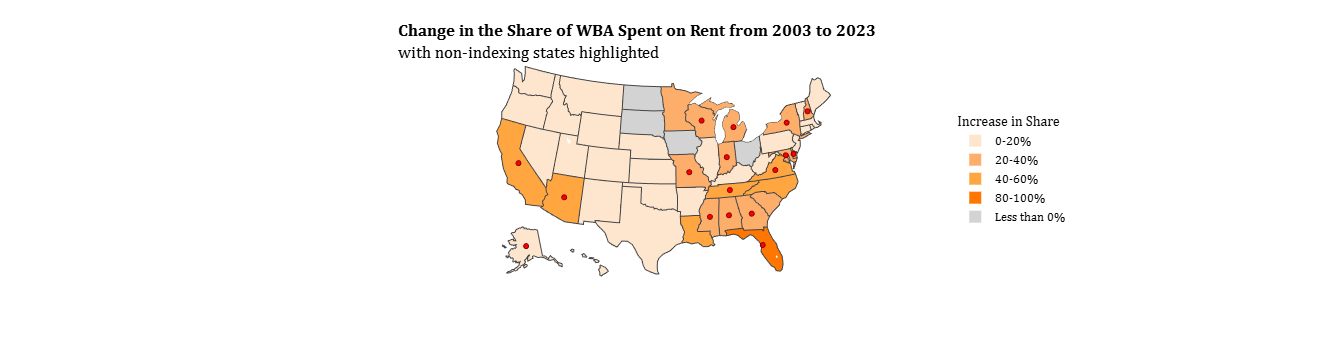

In [44]:
fig = px.choropleth(
    changes_rents_wbas,
    locations='State',
    locationmode='USA-states',
    color='WBA Rent Share Change',
    color_discrete_map=color_map,
    scope='usa',
    labels={'Increase in Share': 'Increase in Share'},
    category_orders={'Increase in Share': category_order}
)

fig.update_layout(
    title={
        'text': "<b>Change in the Share of WBA Spent on Rent from 2003 to 2023</b><br>with non-indexing states highlighted",
        'x': 0.3,
        'y': 0.9,
        'xanchor': 'left'
    },
    font=dict(
        family="Cambria",  
        size=12,         
        color="black",
    ),
    coloraxis_colorbar=dict(
        title='Increase in Share',
        x=0.75,            
        len=1,           
        thickness=10,      
        ticks='outside',
        tickfont=dict(size=10),
    )
)

fig.add_trace(go.Scattergeo(
    locationmode='USA-states',
    locations=nonindexers_list,
    mode='markers+text',   # markers will appear roughly at state centroids
    marker=dict(
        size=5,
        color='red',
        line=dict(width=1, color='darkred'),
        symbol='circle'  # open circle marker
    ),
    showlegend=False
))

fig.update_layout(
    legend=dict(
        x=0.75, 
        y=0.5, 
        xanchor="left",
        title="Increase in Share"
    )
)

fig.show()

In [18]:
changes_rents_wbas[changes_rents_wbas['Nonindexer'] == 1][['WBA Rent Share Change']].mean()

WBA Rent Share Change    0.366627
dtype: float64

In [19]:
changes_rents_wbas[changes_rents_wbas['Nonindexer'] == 0][['WBA Rent Share Change']].mean()

WBA Rent Share Change    0.105482
dtype: float64

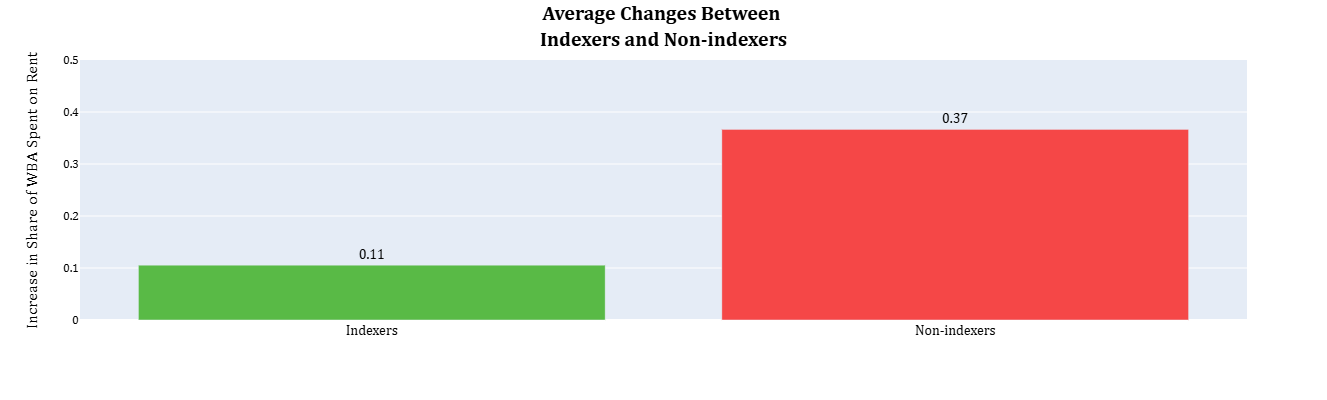

In [20]:
df = pd.DataFrame({
    'Category': ['Indexers', 'Non-indexers'],
    'Value': [0.105482, 0.366627]
})
color_map = {'Indexers': 'rgba(89, 186, 70, 1)', 'Non-indexers': 'rgba(245, 71, 71,1)'}

# Create bar chart
fig = px.bar(
    df,
    x='Category',
    y='Value',
    color='Category',
    color_discrete_map=color_map,
    text='Value'
)

# Customize layout
fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig.update_yaxes(range=[0, 0.5], title='Increase in Share of WBA Spent on Rent')
fig.update_layout(
    title='<b>Average Changes Between <br>Indexers and Non-indexers</b>'
)
fig.update_layout(
    title={
        'text': '<b>Average Changes Between <br>Indexers and Non-indexers</b>',
        'x': 0.5,       # 0=left, 0.5=center, 1=right
        'y': 0.95,      # vertical position (default ~0.9)
        'xanchor': 'center',
        'yanchor': 'top'
    },
    font=dict(
        family='Cambria',
        size=14,
        color='black'
    ),
    showlegend=False,
    xaxis_title = "",
    width=400,   
    height=400,
    yaxis_title_font=dict(size=16),
    yaxis_tickfont=dict(size=12)
)

fig.show()
